In [66]:
from kneed import KneeLocator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [61]:
params_weak = pd.read_csv("params_weak.csv")
params_fix = pd.read_csv("params_fix.csv")
params_chang = pd.read_csv("params_chang.csv")
params_weak["treatment"] = "weak"
params_chang["treatment"] = "chang"
params_fix["treatment"] = "fix"
actions = pd.read_csv("actions.csv")


In [62]:
params_fix.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'user', 'type', 'score', 'type_adj', 'score_adj', 'a', 'v', 't', 'z',
       'y', 'y_adj', 'a10', 'v10', 't10', 'z10', 'a20', 'v20', 't20', 'z20',
       'a30', 'v30', 't30', 'z30', 'a40', 'v40', 't40', 'z40', 'a50', 'v50',
       't50', 'z50', 'a60', 'v60', 't60', 'z60', 'a70', 'v70', 't70', 'z70',
       'a80', 'v80', 't80', 'z80', 'a90', 'v90', 't90', 'z90', 'degrees',
       'a_st10', 'v_st10', 't_st10', 'z_st10', 'a_st20', 'v_st20', 't_st20',
       'z_st20', 'a_st30', 'v_st30', 't_st30', 'z_st30', 'a_st40', 'v_st40',
       't_st40', 'z_st40', 'a_st50', 'v_st50', 't_st50', 'z_st50', 'a_st60',
       'v_st60', 't_st60', 'z_st60', 'a_st70', 'v_st70', 't_st70', 'z_st70',
       'a_st80', 'v_st80', 't_st80', 'z_st80', 'a_st90', 'v_st90', 't_st90',
       'z_st90', 'a_st100', 'v_st100', 't_st100', 'z_st100', 'a100', 'v100',
       't100', 'z100', 'treatment'],
      dtype='object')

In [35]:
curve_w = params_weak.mean()[["a10","a20","a30","a40","a50","a60","a70","a80","a90","a100"]]
curve_f = params_fix.mean()[["a10","a20","a30","a40","a50","a60","a70","a80","a90","a100"]]
curve_c = params_chang.mean()[["a10","a20","a30","a40","a50","a60","a70","a80","a90","a100"]]

In [56]:
#Receives a list of players to show
def get_params(param, players, treatment, column2 = None):
    param_cols = ["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]
    param_sd = ["%s_st%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])] 
    params = pd.melt(treatment.loc[treatment.user.isin(players)], id_vars=['user'], value_vars = param_cols)
    sds = pd.melt(treatment.loc[treatment.user.isin(players)], id_vars=['user'], value_vars = param_sd)
    d = params.groupby("variable").mean()
    d.index = pd.to_numeric(d.index.str.replace(param, ""))
    d_sd = sds.groupby("variable").mean()
    d_sd.index = pd.to_numeric(d_sd.index.str.replace("%s_st" % (param), ""))
    d_sd["round"] = d_sd.index
    d["round"] = d.index
    d = d.merge(d_sd, on = "round")
    d = d.sort_values(by="round")
    d.rename(columns = {"value_x":param, "value_y":"std"}, inplace=True)
    return d

In [76]:
knee_w = KneeLocator(list(range(10,110, 10)), curve_w, S=1.0, curve="convex", direction="decreasing")
knee_f = KneeLocator(list(range(10,110, 10)), curve_f, S=1.0, curve="convex", direction="decreasing")
knee_c = KneeLocator(list(range(10,110, 10)), curve_c, S=1.0, curve="convex", direction="decreasing")

<Figure size 1000x1000 with 0 Axes>

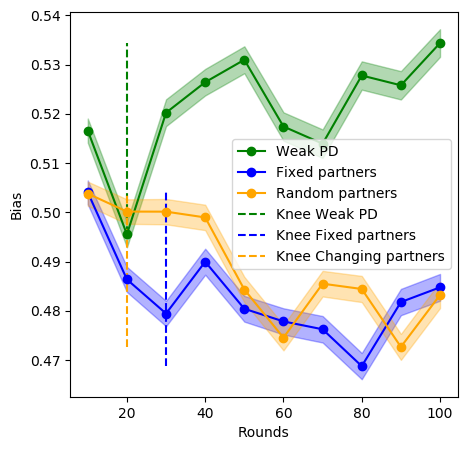

In [126]:
param = "z"

curve_w = params_weak.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_f = params_fix.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]
curve_c = params_chang.mean()[["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]]

knee_w = KneeLocator(list(range(10,110, 10)), curve_w, S=1.0, curve="convex", direction="decreasing")
knee_f = KneeLocator(list(range(10,110, 10)), curve_f, S=1.0, curve="convex", direction="decreasing")
knee_c = KneeLocator(list(range(10,110, 10)), curve_c, S=1.0, curve="convex", direction="decreasing")

weak = get_params(param, actions.user, params_weak)
chang = get_params(param, actions.user, params_chang)
fix = get_params(param, actions.user, params_fix)

errWeak = weak["std"] / np.sqrt(5000)
errChang = chang["std"] / np.sqrt(5000)
errFix = fix["std"] / np.sqrt(5000)


plt.figure(figsize = (10,10))
plt.figure(figsize=(5,5))
plt.plot(weak["round"], weak[param],"-o",label = "Weak PD", color = "green")
plt.plot(fix["round"], fix[param],"-o",label = "Fixed partners", color = "blue")
plt.plot(chang["round"], chang[param],"-o",label = "Random partners", color = "orange")
plt.fill_between(weak["round"], weak[param] + (errWeak * 1.96), weak[param] - (errWeak * 1.96), alpha = 0.3, color = "green")
plt.fill_between(fix["round"], fix[param] + (errFix * 1.96), fix[param] - (errFix * 1.96), alpha = 0.3, color = "blue")
plt.fill_between(chang["round"], chang[param] + (errChang * 1.96), chang[param] - (errChang * 1.96), alpha = 0.3, color = "orange")
plt.vlines(knee_w.knee, weak[param].min(), weak[param].max(), linestyles="--", color = "green", label = "Knee Weak PD")
plt.vlines(knee_f.knee, fix[param].min(), fix[param].max(), linestyles="--", color = "blue", label = "Knee Fixed partners")
plt.vlines(knee_c.knee, chang[param].min(), chang[param].max(), linestyles="--", color = "orange", label = "Knee Changing partners")
plt.xlabel("Rounds")
plt.ylabel("Bias")
plt.legend()

In [95]:
knee_w.knee

10

In [63]:
get_params("a", actions.user, params_fix)

,a,round,std
0,4.207235,10,0.578386
2,3.387218,20,0.577715
3,3.076558,30,0.552221
4,2.927779,40,0.563840
5,2.862352,50,0.540913
6,2.700166,60,0.545283
7,2.710307,70,0.571851
8,2.668753,80,0.552202
9,2.776231,90,0.563605
1,2.531026,100,0.555258


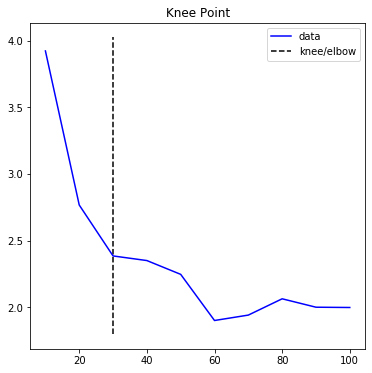

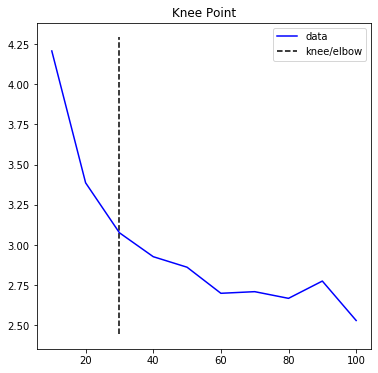

In [46]:
knee_w.plot_knee()
knee_f.plot_knee()

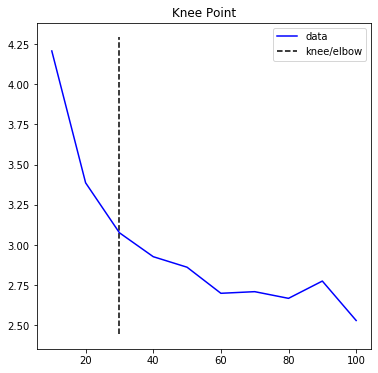

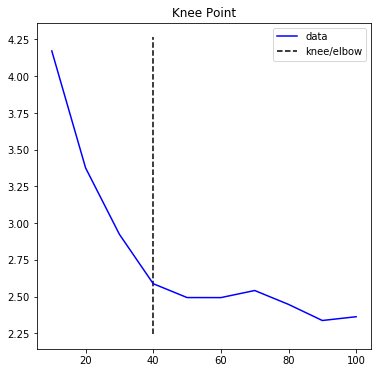

In [42]:
knee_c.plot_knee()